## Librerías

In [26]:
# Tratamientos de datos y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

#Statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Metricas
from sklearn.metrics import mean_absolute_percentage_error

#Skforecast
# from skforecast.Sarimax import Sarimax
# from skforecast.ForecasterSarimax import ForecasterSarimax

#Advertencias
import warnings
warnings.filterwarnings('ignore')

## Datos
Resumen del consumo mensual de combustible en españa

In [22]:
datos = pd.read_csv('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv', sep = ',')
datos

,Fecha,GLPs,Gasolinas,Querosenos,Gasoleos,Fueloleos
0,1969-01-01,133615.09620,166875.2129,123257.8090,4.011853e+05,912583.4202
1,1969-02-01,126748.47410,155466.8105,114682.5767,3.853600e+05,851877.8115
2,1969-03-01,107795.80910,184983.6699,109970.0796,4.189556e+05,873884.2933
3,1969-04-01,96683.15967,202319.8164,108797.9255,4.389755e+05,755490.1170
4,1969-05-01,79506.23804,206259.1523,103554.0784,4.674519e+05,729963.6009
...,...,...,...,...,...,...
639,2022-04-01,179591.64000,471601.9400,494966.3200,2.638030e+06,636930.4200
640,2022-05-01,134166.56000,478873.4100,530034.0100,2.673797e+06,708289.2600
641,2022-06-01,142480.09000,501447.1400,540594.9700,2.648087e+06,667221.4500
642,2022-07-01,135984.49000,534584.6800,607854.6800,2.613591e+06,691371.6000


In [23]:
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha': 'date', 'Gasolinas':'litters'})

datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos.set_index('date', inplace=True)
datos.head()

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


In [24]:
datos= datos.loc[:'1990-01-01']
datos

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523
...,...
1989-09-01,687649.2852
1989-10-01,669889.1602
1989-11-01,601413.8867


In [25]:
datos = datos.asfreq('MS')
datos = datos['litters']
type(datos) #Verificar que se vuelva serie de tiempo

pandas.core.series.Series

Crear un conjunto de ajuste y un conjunto de validación

In [30]:
fin_ajuste = '1980-01-01'
print(f'Fechas ajuste: {datos.index.min()} --- {datos.loc[:fin_ajuste].index.max()} n={len(datos.loc[:fin_ajuste])}')

print(f'Fechas validación: {datos.loc[fin_ajuste:].index.min()} --- {datos.loc[fin_ajuste:].index.max()} n={len(datos.loc[fin_ajuste:])}')

Fechas ajuste: 1969-01-01 00:00:00 --- 1980-01-01 00:00:00 n=133
Fechas validación: 1980-01-01 00:00:00 --- 1990-01-01 00:00:00 n=121


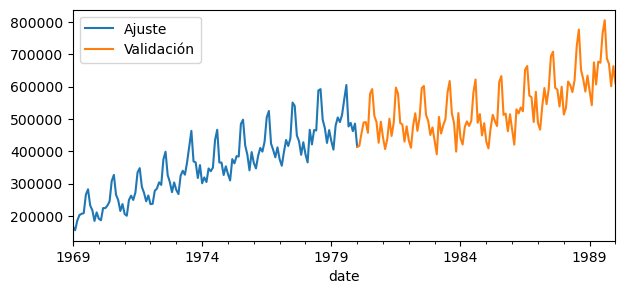

In [34]:
datos_ajuste = datos.loc[:fin_ajuste]
datos_validacion = datos.loc[fin_ajuste:]

plt.figure(figsize=(7,3))

datos_ajuste.plot(label = 'Ajuste')
datos_validacion.plot(label = 'Validación')
plt.legend()

plt.show()


## Análisis SARIMA

1. Estacionariedad
2. Autocorrelación
3. Descomposición


#### Estacionariedad

- Test Dickey - Fuller
- Test KPSS

In [35]:
print('Test de estacionariedad para la serie original')
print('----------------------------------------------')

adfuller_result = adfuller(datos)
kpss_result = kpss(datos)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie original
----------------------------------------------
Estadistico ADF: -0.44612980998228685, p-value: 0.9021071923942653
Estadistico KPSS: 2.2096370946978388, p-value: 0.01


In [36]:
datos_diff_1 = datos.diff().dropna()

print('Test de estacionariedad para la serie diferencial en orden 1')
print('----------------------------------------------')

adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos_diff_1)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferencial en orden 1
----------------------------------------------
Estadistico ADF: -2.4592855854332734, p-value: 0.12569738231750477
Estadistico KPSS: 0.3132711623572763, p-value: 0.1


In [37]:
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test de estacionariedad para la serie diferencial en orden 1')
print('----------------------------------------------')

adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos_diff_2)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferencial en orden 1
----------------------------------------------
Estadistico ADF: -11.117483376374473, p-value: 3.533286742436514e-20
Estadistico KPSS: 0.08065668267482089, p-value: 0.1
